# Generic Scikit-Learn Classifier With Dask

Run any scikit-learn compatible classifier or list of classifiers

In [10]:
# nuclio: ignore
import nuclio

In [11]:
%nuclio config kind = "dask"
%nuclio config spec.image = "mlrun/ml-models"

%nuclio: setting kind to 'dask'
%nuclio: setting spec.image to 'mlrun/ml-models'


In [12]:
import warnings
warnings.filterwarnings('ignore')

import os
import joblib
import numpy as np
import pandas as pd
import sklearn
from cloudpickle import dumps, load, dump
from typing import List, Optional

from dask.distributed import Client
from dask import dataframe as dd
from dask import array as da
from dask.delayed import delayed
from dask_ml import model_selection
from dask_ml import metrics
from dask_ml.preprocessing import LabelEncoder, StandardScaler

from mlrun.execution import MLClientCtx
from mlrun.datastore import DataItem
from mlrun.artifacts import PlotArtifact
from mlrun.mlutils import (gen_sklearn_model, create_class)
import mlrun

import matplotlib.pyplot as plt
from yellowbrick.classifier import ROCAUC, ClassificationReport, ConfusionMatrix
from yellowbrick.model_selection import FeatureImportances

In [13]:
def train_model(context: MLClientCtx,
                dataset: DataItem,
                model_pkg_class: str,
                label_column: str = "label",
                train_validation_size: float = 0.75,
                sample: float = 1.0,
                models_dest: str = "models",
                test_set_key: str = "test_set",
                plots_dest: str = "plots",
                dask_key: str = "dask_key",
                dask_persist: bool = False,
                scheduler_key: str = None,
                file_ext: str = "parquet",
                random_state: int = 42) -> None:
    
    """
    Train a sklearn classifier with Dask
    
    :param context:                 Function context.
    :param dataset:                 Raw data file.
    :param model_pkg_class:         Model to train, e.g, "sklearn.ensemble.RandomForestClassifier", 
                                    or json model config.
    :param label_column:            (label) Ground-truth y labels.
    :param train_validation_size:   (0.75) Train validation set proportion out of the full dataset.
    :param sample:                  (1.0) Select sample from dataset (n-rows/% of total), randomzie rows as default.
    :param models_dest:             (models) Models subfolder on artifact path.
    :param test_set_key:            (test_set) Mlrun db key of held out data in artifact store.
    :param plots_dest:              (plots) Plot subfolder on artifact path.
    :param dask_key:                (dask key) Key of dataframe in dask client "datasets" attribute.
    :param dask_persist:            (False) Should the data be persisted (through the `client.persist`)
    :param scheduler_key:           (scheduler) Dask scheduler configuration, json also logged as an artifact.
    :param file_ext:                (parquet) format for test_set_key hold out data
    :param random_state:            (42) sklearn seed
    """
    
    if hasattr(context, "dask_client"):
        dask_client = context.dask_client
        dask_client.write_scheduler_file("scheduler.json")
        
    elif scheduler_key != None:
        dask_client = Client(scheduler_file=str(scheduler_key))
        dask_client.write_scheduler_file(scheduler_key + ".json")
        
    else:
        dask_client = Client()
        dask_client.write_scheduler_file("scheduler.json")
        
    if dask_persist:
        df = dask_client.persist(df)
        if dask_client.datasets and dask_key in dask_client.datasets:
            dask_client.unpublish_dataset(dask_key)
        dask_client.publish_dataset(df, name=dask_key)
    
    if context:
        context.dask_client = dask_client
    
    context.logger.info("Read Data")
    temp = dataset.as_df() # fix dask df ability
    
    # read data with dask
    df = dd.from_pandas(temp, chunksize=100000)
    df_header = df.columns
    
    # take only numrical cols
    context.logger.info("Prep Data")
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    df = df.select_dtypes(include=numerics)
    
    # fillna
    df = df.dropna()
    
    # randomize rows or sample
    df = df.sample(frac=sample).reset_index(drop=True)
    
    # fetch x and y
    encoder = LabelEncoder()
    encoder = encoder.fit(df[label_column])
    X = df.drop(label_column, axis=1).to_dask_array(lengths=True)
    y = encoder.transform(df[label_column])

    # get classes with dask
    classes = df[label_column].drop_duplicates()
    classes = [str(i) for i in classes]

    # split train test
    context.logger.info("Split and Train")
    X_train, X_test, y_train, y_test = delayed(model_selection.train_test_split)(X, y, 
                                                                                 train_size=train_validation_size,
                                                                                 random_state=random_state).compute()
    
    # scale data with minmax scaler
    scaler = StandardScaler()
    scaler = scaler.fit(X_train)
    X_train_transformed = scaler.transform(X_train)
    X_test_transformed = scaler.transform(X_test)
    
    # generate a model configuration and add CLASS and FIT params:
    model_config = gen_sklearn_model(model_pkg_class,
                                     context.parameters.items())

    # update FIT params with features and labels:
    model_config["FIT"].update({"X": X_train_transformed,
                                "y": y_train})
    
    # generate a scikit-learn class:
    ClassifierClass = create_class(model_config["META"]["class"])
    
    # instantiate the class with our updated CLASS params:
    model = ClassifierClass(**model_config["CLASS"])
    
    # load and fit model
    with joblib.parallel_backend("dask"):
        
        # initialize classifier from sklearn
        model = delayed(model.fit)(**model_config["FIT"]).compute()

    # log artifacts
    artifact_path = context.artifact_subpath(models_dest)
    
    # log plots
    plots_path = context.artifact_subpath(models_dest, plots_dest)

    # create reports
    context.logger.info("Evaluate")
    extra_data_dict = {}
    for report in (ROCAUC, ClassificationReport, ConfusionMatrix):
        
        report_name = str(report.__name__)
        # clear output
        plt.cla()
        plt.clf()
        plt.close()
        
        # genrate report
        viz = report(model, classes=classes, per_class=True, is_fitted=True)
        viz.fit(X_train_transformed, y_train)        # Fit the training data to the visualizer
        viz.score(X_test_transformed, y_test)        # Evaluate the model on the test data
        
        # log reports
        plot = context.log_artifact(PlotArtifact(report_name, 
                                                 body=viz.fig,
                                                 title=report_name), 
                                                 db_key=False)
        extra_data_dict[str(report)] = plot
        
        # log results
        if report_name == 'ROCAUC':
            context.log_results({"micro": viz.roc_auc.get("micro"),
                                "macro": viz.roc_auc.get("macro")})
            
        elif report_name == 'ClassificationReport':
            for score_name in viz.scores_:
                for score_class in viz.scores_[score_name]:
                    
                    context.log_results({score_name + "-" + score_class : 
                                         viz.scores_[score_name].get(score_class)})
        
        viz.show()
    
    # get feature importance
    viz = FeatureImportances(model, classes=classes, per_class=True, is_fitted=True, labels=df_header)
    viz.fit(X_train_transformed, y_train) 
    viz.score(X_test_transformed, y_test)
    viz.show()
    
    plot = context.log_artifact(PlotArtifact("FeatureImportances", body=viz.fig, 
                                             title="FeatureImportances"), db_key=False)
    extra_data_dict[str("FeatureImportances")] = plot
    
    # clear final output
    plt.cla()
    plt.clf()
    plt.close()

    # log artifacts
    context.logger.info("Log artifacts")
    artifact_path = context.artifact_subpath(models_dest)
    
    # log plots
    plots_path = context.artifact_subpath(models_dest, plots_dest)
    
    # set label
    context.set_label('class', model_pkg_class)
    
    # log models
    context.log_model("model", body=dumps(model),
                      artifact_path=artifact_path,
                      model_file="model.pkl",
                      extra_data=extra_data_dict,
                      metrics=context.results,
                      labels={"class": model_pkg_class})
    
    # log scalers
    context.log_artifact("standard_scaler", body=dumps(scaler),
                         artifact_path=artifact_path,
                         model_file="scaler.gz",
                         label="standard_scaler")
    
    # log encoder
    context.log_artifact("label_encoder", body=dumps(encoder),
                         artifact_path=artifact_path,
                         model_file="encoder.gz",
                         label="label_encoder")
    
    # set aside some test data
    df_to_save = delayed(np.column_stack)((X_test, y_test)).compute()
    context.log_dataset(test_set_key, 
                        df=pd.DataFrame(df_to_save, columns=df_header), # talk with the team
                        format=file_ext, index=False, 
                        labels={"data-type": "held-out"},
                        artifact_path=context.artifact_subpath('data'))
    
    context.logger.info("Done!")

### Save and Config

In [14]:
dsf = mlrun.code_to_function('sklearn-classifier-dask', kind='dask', code_output=".") .apply(mlrun.mount_v3io())

In [15]:
dsf.spec.image = 'mlrun/ml-models'
dsf.spec.remote = True
dsf.spec.replicas = 1
dsf.spec.service_type = 'NodePort'
dsf.export("function.yaml")

> 2020-10-25 12:15:36,910 [info] function spec saved to path: function.yaml


### Set Environment

In [16]:
artifact_path = mlrun.set_environment(api_path = 'http://mlrun-api:8080',
                                      artifact_path = os.path.abspath('./'))

### Set Parameters

In [17]:
DATA_URL = 'https://s3.wasabisys.com/iguazio/data/iris/iris_dataset.csv'

task_params = {
    "params" : {
        "sample"             : 1,
        "test_size"          : 0.30,
        "train_val_split"    : 0.75,
        "random_state"       : 42,
        "n_jobs"             : -1,
        "plots_dest"         : "plots-p",
        "models_dest"        : 'sklearn-clfmodel'}}


models = [
    "sklearn.ensemble.RandomForestClassifier", 
    "sklearn.linear_model.LogisticRegression",
    "sklearn.ensemble.AdaBoostClassifier"
]

### Test and Run

> 2020-10-25 12:15:36,942 [info] starting run sklearn_ensemble_RandomForestClassifier uid=b4e10216561041ef91d9367d05f4bad4  -> http://mlrun-api:8080
> 2020-10-25 12:15:41,702 [info] trying dask client at: tcp://mlrun-sklearn-classifier-dask-9a10c372-9.default-tenant:8786
> 2020-10-25 12:15:41,721 [info] using remote dask scheduler (mlrun-sklearn-classifier-dask-9a10c372-9) at: tcp://mlrun-sklearn-classifier-dask-9a10c372-9.default-tenant:8786


> 2020-10-25 12:15:41,872 [info] Read Data
> 2020-10-25 12:15:42,034 [info] Prep Data
> 2020-10-25 12:15:45,506 [info] Split and Train
> 2020-10-25 12:15:46,182 [info] Evaluate


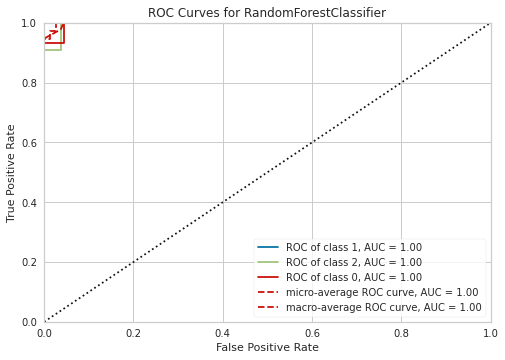

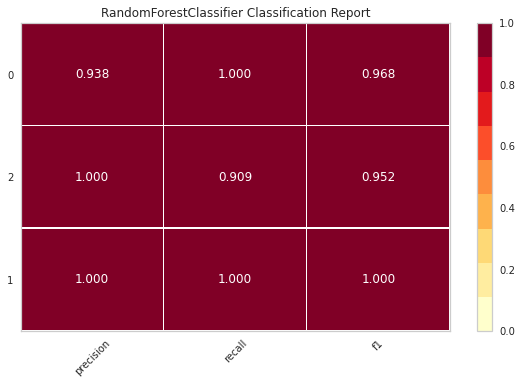

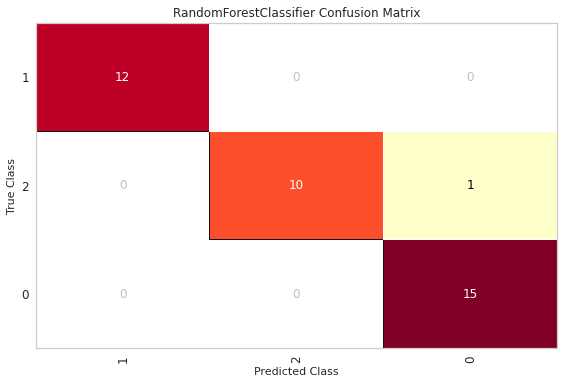

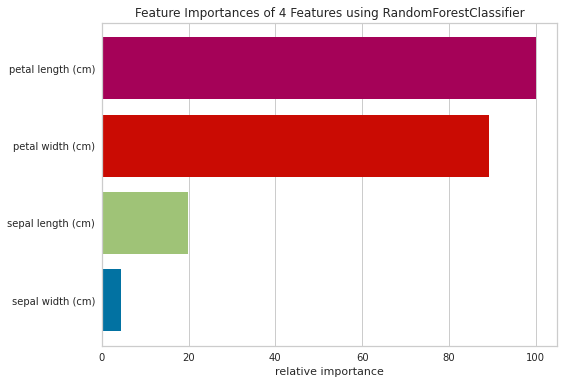

> 2020-10-25 12:15:47,124 [info] Log artifacts
> 2020-10-25 12:15:47,691 [info] Done!
> 2020-10-25 12:15:41,872 [info] Read Data
> 2020-10-25 12:15:42,034 [info] Prep Data
> 2020-10-25 12:15:45,506 [info] Split and Train
> 2020-10-25 12:15:46,182 [info] Evaluate
> 2020-10-25 12:15:47,124 [info] Log artifacts
> 2020-10-25 12:15:47,691 [info] Done!

> 2020-10-25 12:15:47,747 [warning] run ended with state 


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...05f4bad4,0,Oct 25 12:15:37,completed,sklearn_ensemble_RandomForestClassifier,v3io_user=adminkind=daskowner=adminhost=jupyter-856469cd66-vd7fwclass=sklearn.ensemble.RandomForestClassifier,dataset,model_pkg_class=sklearn.ensemble.RandomForestClassifierlabel_column=labelCLASS_max_depth=5,micro=0.9989612188365651macro=0.9985442183509817precision-1=1.0precision-2=1.0precision-0=0.9375recall-1=1.0recall-2=0.9090909090909091recall-0=1.0f1-1=1.0f1-2=0.9523809523809523f1-0=0.967741935483871,ROCAUCClassificationReportConfusionMatrixFeatureImportancesmodelstandard_scalerlabel_encodertest_set


to track results use .show() or .logs() or in CLI: 
!mlrun get run b4e10216561041ef91d9367d05f4bad4 --project default , !mlrun logs b4e10216561041ef91d9367d05f4bad4 --project default
> 2020-10-25 12:15:47,762 [info] run executed, status=completed
> 2020-10-25 12:15:47,763 [info] starting run sklearn_linear_model_LogisticRegression uid=6198ad4ab73f4e6db15533c7bca1299b  -> http://mlrun-api:8080
> 2020-10-25 12:15:47,888 [info] trying dask client at: tcp://mlrun-sklearn-classifier-dask-9a10c372-9.default-tenant:8786
> 2020-10-25 12:15:47,895 [info] using remote dask scheduler (mlrun-sklearn-classifier-dask-9a10c372-9) at: tcp://mlrun-sklearn-classifier-dask-9a10c372-9.default-tenant:8786


> 2020-10-25 12:15:47,900 [info] Read Data
> 2020-10-25 12:15:48,016 [info] Prep Data
> 2020-10-25 12:15:48,189 [info] Split and Train
> 2020-10-25 12:15:48,277 [info] Evaluate


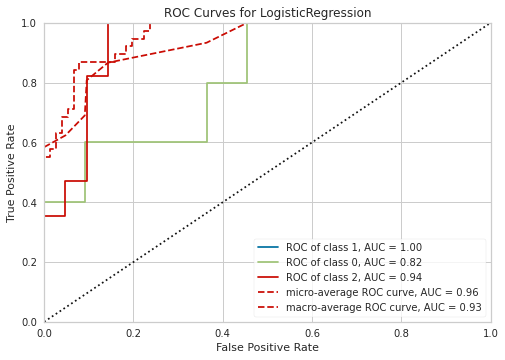

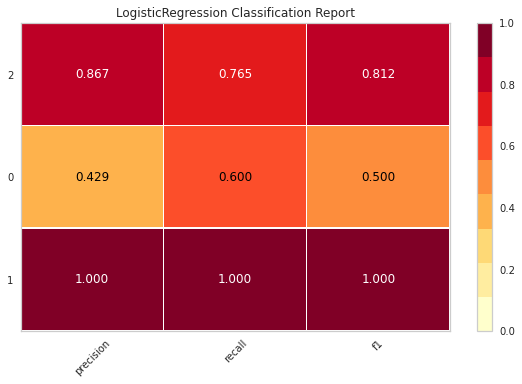

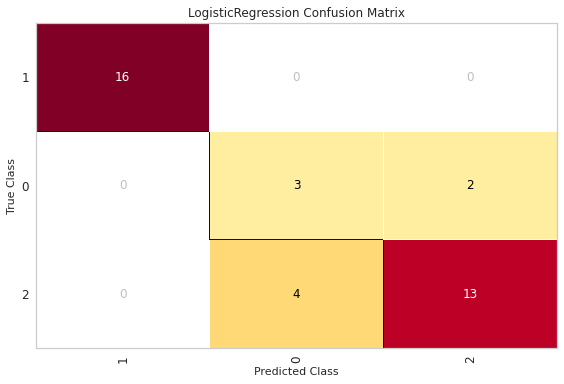

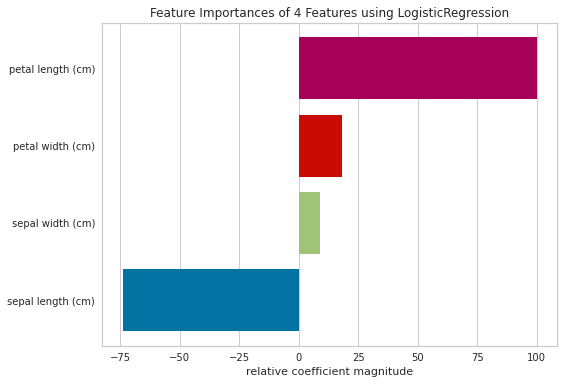

> 2020-10-25 12:15:49,186 [info] Log artifacts
> 2020-10-25 12:15:49,446 [info] Done!
> 2020-10-25 12:15:47,900 [info] Read Data
> 2020-10-25 12:15:48,016 [info] Prep Data
> 2020-10-25 12:15:48,189 [info] Split and Train
> 2020-10-25 12:15:48,277 [info] Evaluate
> 2020-10-25 12:15:49,186 [info] Log artifacts
> 2020-10-25 12:15:49,446 [info] Done!

> 2020-10-25 12:15:49,500 [warning] run ended with state 


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...bca1299b,0,Oct 25 12:15:47,completed,sklearn_linear_model_LogisticRegression,v3io_user=adminkind=daskowner=adminhost=jupyter-856469cd66-vd7fwclass=sklearn.linear_model.LogisticRegression,dataset,model_pkg_class=sklearn.linear_model.LogisticRegressionlabel_column=labelCLASS_solver=liblinear,micro=0.9577562326869806macro=0.932340208810797precision-1=1.0precision-0=0.42857142857142855precision-2=0.8666666666666667recall-1=1.0recall-0=0.6recall-2=0.7647058823529411f1-1=1.0f1-0=0.5f1-2=0.8125,ROCAUCClassificationReportConfusionMatrixFeatureImportancesmodelstandard_scalerlabel_encodertest_set


to track results use .show() or .logs() or in CLI: 
!mlrun get run 6198ad4ab73f4e6db15533c7bca1299b --project default , !mlrun logs 6198ad4ab73f4e6db15533c7bca1299b --project default
> 2020-10-25 12:15:49,515 [info] run executed, status=completed
> 2020-10-25 12:15:49,516 [info] starting run sklearn_ensemble_AdaBoostClassifier uid=35d29dde140e4d608c792ddb841d2557  -> http://mlrun-api:8080
> 2020-10-25 12:15:49,620 [info] trying dask client at: tcp://mlrun-sklearn-classifier-dask-9a10c372-9.default-tenant:8786
> 2020-10-25 12:15:49,626 [info] using remote dask scheduler (mlrun-sklearn-classifier-dask-9a10c372-9) at: tcp://mlrun-sklearn-classifier-dask-9a10c372-9.default-tenant:8786


> 2020-10-25 12:15:49,632 [info] Read Data
> 2020-10-25 12:15:49,742 [info] Prep Data
> 2020-10-25 12:15:49,907 [info] Split and Train
> 2020-10-25 12:15:50,279 [info] Evaluate


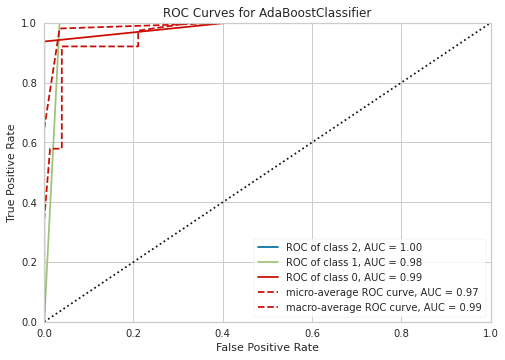

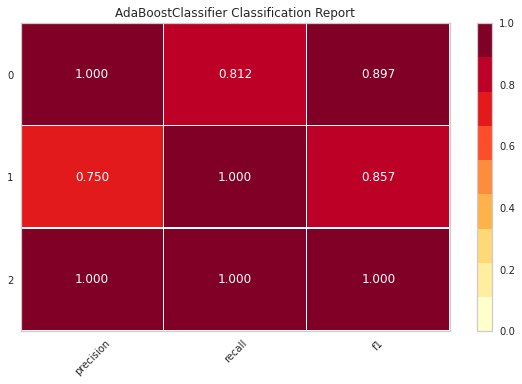

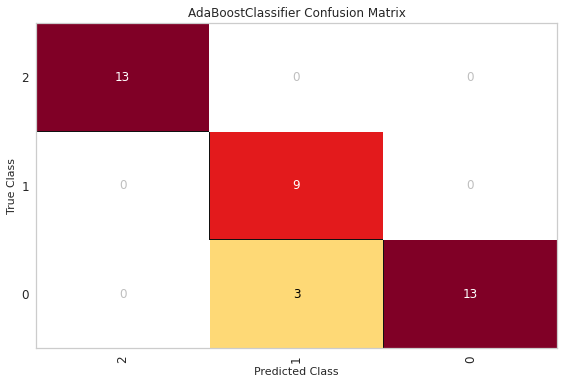

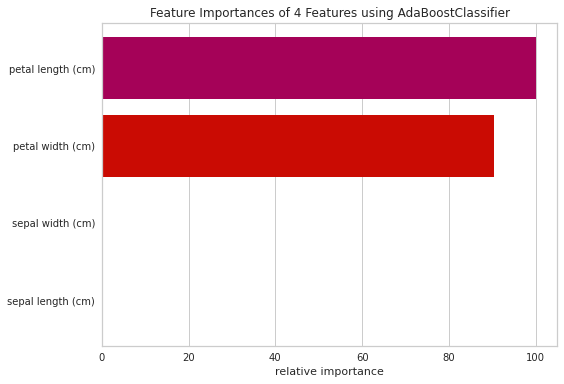

> 2020-10-25 12:15:51,309 [info] Log artifacts
> 2020-10-25 12:15:51,616 [info] Done!
> 2020-10-25 12:15:49,632 [info] Read Data
> 2020-10-25 12:15:49,742 [info] Prep Data
> 2020-10-25 12:15:49,907 [info] Split and Train
> 2020-10-25 12:15:50,279 [info] Evaluate
> 2020-10-25 12:15:51,309 [info] Log artifacts
> 2020-10-25 12:15:51,616 [info] Done!

> 2020-10-25 12:15:51,667 [warning] run ended with state 


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...841d2557,0,Oct 25 12:15:49,completed,sklearn_ensemble_AdaBoostClassifier,v3io_user=adminkind=daskowner=adminhost=jupyter-856469cd66-vd7fwclass=sklearn.ensemble.AdaBoostClassifier,dataset,model_pkg_class=sklearn.ensemble.AdaBoostClassifierlabel_column=labelCLASS_n_estimators=200CLASS_learning_rate=0.01,micro=0.9667590027700831macro=0.9899915099268548precision-2=1.0precision-1=0.75precision-0=1.0recall-2=1.0recall-1=1.0recall-0=0.8125f1-2=1.0f1-1=0.8571428571428571f1-0=0.896551724137931,ROCAUCClassificationReportConfusionMatrixFeatureImportancesmodelstandard_scalerlabel_encodertest_set


to track results use .show() or .logs() or in CLI: 
!mlrun get run 35d29dde140e4d608c792ddb841d2557 --project default , !mlrun logs 35d29dde140e4d608c792ddb841d2557 --project default
> 2020-10-25 12:15:51,684 [info] run executed, status=completed


In [18]:
outputs = []
for model in models:
    task_copy = task_params.copy()
    task_copy.update(
        {
            "params":{ "model_pkg_class" : model,
                       "label_column"    : "label"}
        }
    )
    
    # customize specific model parameters
    if "RandomForestClassifier" in model:
        task_copy["params"].update({"CLASS_max_depth" : 5})

    if "LogisticRegression" in model:
        task_copy["params"].update({"CLASS_solver" : "liblinear"})
    
    if "AdaBoostClassifier" in model:
        task_copy["params"].update({"CLASS_n_estimators"  : 200,
                                    "CLASS_learning_rate" : 0.01
                                   })
    
    name = model.replace('.', '_')
    output = dsf.run(mlrun.NewTask(**task_copy),
                             handler=train_model,
                             name=name,
                             inputs={"dataset"  : DATA_URL}, 
                             artifact_path=os.path.join(artifact_path, model))
    
    outputs.append({name: output.outputs})